partially generated using copilot
this does the following:
- goes through each folder in the path,

- grabs the modify time of this file:
[folder]/network_files/[network cutoff folder]/mix/"mix_c0.30.network"
this is the network file that is generated during distance calculation

- grabs the **creation** time of this file:
[folder]/html_content/networks/[network cutoff folder]/mix/bs_networks.js
this file is created during the gcf calling step.
bigscape v1 crashes during the creation of this file in large datasets

- grabs the last modified time of this file:
[folder]/logs/runtimes.txt
this is the last file to be touched during the execution of bigscape v1

- calculates the difference between the network file mtime and runtimes.txt file ctime
this is the total execution time of the gcf calling step
- calculates the difference between the creation time of the js file and the runtimes.txt file
this is the portion that is missing in the v1 crash

- after collecting all the data, calculates the missing time as a projection

In [1]:
from datetime import timedelta
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="white")

COLORS = {
    "bigscape_blue": "#52A3A3",
    "dark_blue": "#0E75BB",
    "orange_i_found_on_bigscape_image": "#F7931E",
    "antismash_red": "#AA0000",
    "bigslice_grey": "#515154",
}

mpl.rcParams["svg.fonttype"] = "none"

R^2: 0.9955
Estimated missing run time for 50k samples: 2154.0 seconds
Estimated runtime for 50k samples: 153030 seconds


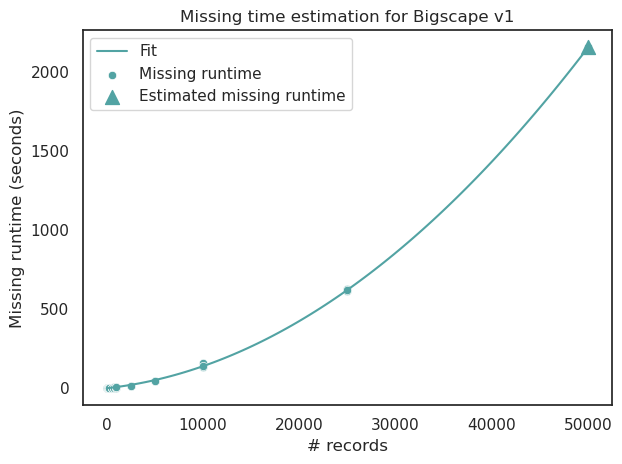

In [ ]:
# convert all to numpy arrays
crashed_run_estimate_source = pd.read_csv("source_data/bigscape_v1_crash_timings.csv")

# convert to numpy array
crashed_run_estimate_array = crashed_run_estimate_source.to_numpy()

# get the pre-crash time for 50k samples
crashed_run_50k_row = crashed_run_estimate_array[
    crashed_run_estimate_array[:, 0] == 50000
]
pre_crash_50k = crashed_run_50k_row[0, 4]

# omit 50k
crashed_run_estimate_array = crashed_run_estimate_array[
    crashed_run_estimate_array[:, 0] != 50000
]

# fit a polynomial to the data
p = np.polyfit(
    crashed_run_estimate_array[:, 0],
    crashed_run_estimate_array[:, 6],
    2,
)

np.polyfit_coeffs = p


# calculate R^2
# sum squares of the residuals
residuals = crashed_run_estimate_array[:, 6] - np.polyval(np.polyfit_coeffs, crashed_run_estimate_array[:, 0])

ss_res = np.sum(residuals**2)
# total sum of squares
ss_tot = np.sum((crashed_run_estimate_array[:, 1] - np.mean(crashed_run_estimate_array[:, 6]))**2)
# R^2
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2: {r_squared:.4f}")


# get the estimated post crash time for 50k samples, round to nearest second
estimate_missing_time = np.polyval(np.polyfit_coeffs, 50000).round(0)

# add estimated missing time to the 50k row
crashed_run_50k_row[0, 6] = estimate_missing_time

print(
    f"Estimated missing run time for 50k samples: {estimate_missing_time} seconds"
)

# calculate total runtime
estimate_runtime = pre_crash_50k + estimate_missing_time

# add total runtime to 50k row
crashed_run_50k_row[0, 5] = estimate_runtime
    
print(f"Estimated runtime for 50k samples: {estimate_runtime:.0f} seconds")

# add the 50k row to the array
crashed_run_estimate_array = np.vstack((crashed_run_estimate_array, crashed_run_50k_row))

# save to csv
pd.DataFrame(crashed_run_estimate_array, columns=crashed_run_estimate_source.columns).to_csv(
    "Supplementary_table_7_crash_estimation.csv", index=False
)

# lineplot with the fit
x_fit = np.linspace(0, 50000, 100)
y_fit = np.polyval(np.polyfit_coeffs, x_fit)
sns.lineplot(x=x_fit, y=y_fit, label="Fit", color=COLORS["bigscape_blue"])

# scatterplot with data of the fit
sns.scatterplot(
    x=crashed_run_estimate_array[:, 0],
    y=crashed_run_estimate_array[:, 6],
    label="Missing runtime",
    color=COLORS["bigscape_blue"],
)

# estimation point for 50k
plt.scatter(
    50000,
    estimate_missing_time,
    marker="^",
    color=COLORS["bigscape_blue"],
    s=100,
    label="Estimated missing runtime",
)

plt.legend()

plt.xlabel("# records")
plt.ylabel("Missing runtime (seconds)")
plt.title("Missing time estimation for Bigscape v1")

plt.tight_layout()
plt.savefig("Fig_S10_post_crash_estimation_v1.svg", bbox_inches="tight")

# convert to dataframe for export
df = pd.DataFrame(crashed_run_estimate_array[:,[0, 1, 6]])
# add column names
df.columns = ["# Records", "Sample", "Missing runtime"]

df.to_csv(("Figure_S10.csv"), index=None)